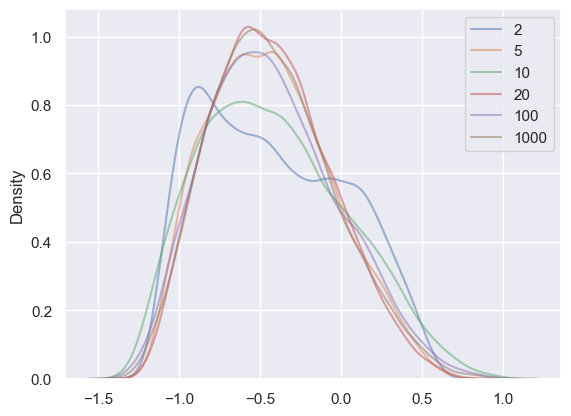

In [72]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

N = 10000
alpha = np.random.randn()
beta = np.random.randn(1000)
for p in [2,5,10,20,100,1000]:
    X = np.random.rand(N*p).reshape((N,p))
    # eta = X.dot(beta[:p]) + alpha
    eta = 2*(X-0.5).dot(beta[:p])/np.sqrt(p) + alpha
    k = 4
    z = 3 * stats.logistic.cdf(eta) - 1.5
    sns.kdeplot(z, alpha=0.5, label=p)
plt.legend();

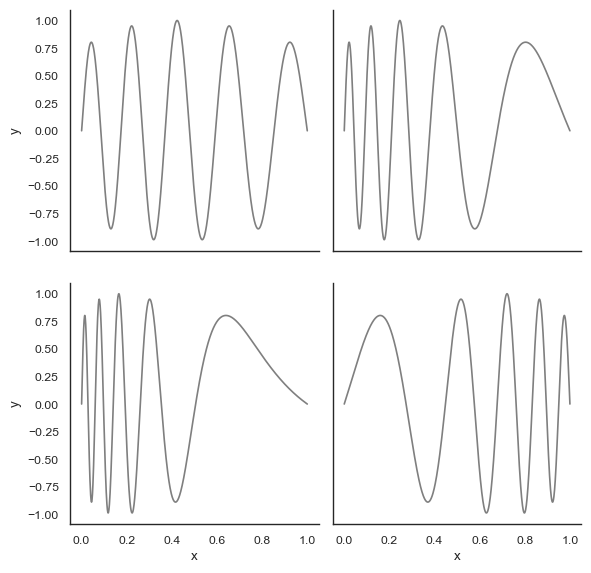

In [74]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()
sns.set_style("white")
sns.set_context("paper")

np.random.seed(44)

N = 10000
p = 10
alpha = np.random.randn()
beta = np.random.randn(p)

t = np.linspace(0,1,1000)
def m(x):
    eta = 2*(x-0.5).dot(beta)/np.sqrt(p) + alpha
    k = 4
    a = 3 * stats.logistic.cdf(eta) - 1.5
    gam_t = (np.exp(k*(a * t)) - 1) / (np.exp(k*a) - 1)
    return (1 - np.power(gam_t - 0.5, 2)) * np.sin(np.pi * 9 * gam_t)

df=pd.DataFrame(data=np.c_[
    np.r_[np.repeat([0],1000), np.repeat([1],1000), np.repeat([2],1000), np.repeat([3],1000)].astype(int),
    np.r_[t,t,t,t],
    np.r_[m(np.random.randn(p)), m(np.random.randn(p)), m(np.random.randn(p)), m(np.random.randn(p))]
], columns=['plot', 'x','y'])

# grid = sns.FacetGrid(df, col="plot", col_wrap=2)
# grid.map(plt.plot, "x", 'y', color='black', alpha=0.5)
# grid.set_titles(row_template = '{row_name}', col_template = '')



plt.savefig('sample_phase.pdf')

In [2]:
import sys, os; sys.path.append(os.path.dirname(os.getcwd())) 
import numpy as np
from scipy import stats
from pyfrechet.metric_spaces import *
from pyfrechet.metric_spaces import FisherRaoPhase
from benchmark import bench

OUT_FILE = 'result_phase_cross_est_new_dgp.json'

def gen_data(N, p, alpha, beta):
    M = FisherRaoPhase(np.linspace(0,1,100))
    def m(x):
        eta = 2*(x-0.5).dot(beta)/np.sqrt(p) + alpha
        k = 4
        a = 3 * stats.logistic.cdf(eta) - 1.5
        t = M.grid
        gam_t = (np.exp(k*(a * t)) - 1) / (np.exp(k*a) - 1)
        return (1 - np.power(gam_t - 0.5, 2)) * np.sin(np.pi * 9 * gam_t)
    
    x = np.random.rand(N*p).reshape((N,p))
    y = np.array([ m(x[i,:]) for i in range(N)])
    return x, MetricData(M, y), MetricData(M, y)

bench(
    gen_data,
    OUT_FILE,
    ps=[2, 5, 10, 20],
    Ns=[50, 100, 200],
    replicas=10
)

[2023-06-08 09:20:40.722472] Progress: N=200	p=20	i=0
[2023-06-08 09:20:40.744696] Distances for cart_2means
[2023-06-08 09:20:40.744716] dt = 0
[2023-06-08 09:20:40.744720] Fitting for cart_2means
[2023-06-08 09:38:51.854426] dt = 1091.1097259521484
[2023-06-08 09:38:51.854591] MSE for cart_2means
[2023-06-08 09:39:12.510346] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:   26.3s
[Parallel(n_jobs=-2)]: Done 186 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:  1.2min finished


[2023-06-08 09:40:21.858466] dt = 69.34804606437683
[2023-06-08 09:40:21.858510] Fitting for medoid_greedy
[2023-06-08 09:40:23.818215] dt = 1.9598209857940674
[2023-06-08 09:40:23.818300] MSE for medoid_greedy
[2023-06-08 09:40:42.456200] Progress: N=200	p=20	i=1
[2023-06-08 09:40:42.468109] Distances for cart_2means
[2023-06-08 09:40:42.468117] dt = 0
[2023-06-08 09:40:42.468120] Fitting for cart_2means
[2023-06-08 09:58:29.353258] dt = 1066.8851237297058
[2023-06-08 09:58:29.353487] MSE for cart_2means
[2023-06-08 09:58:48.836180] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:   27.2s
[Parallel(n_jobs=-2)]: Done 186 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:  1.2min finished


[2023-06-08 10:00:00.186595] dt = 71.35034012794495
[2023-06-08 10:00:00.186642] Fitting for medoid_greedy
[2023-06-08 10:00:02.394400] dt = 2.207876205444336
[2023-06-08 10:00:02.394488] MSE for medoid_greedy
[2023-06-08 10:00:21.191693] Progress: N=200	p=20	i=2
[2023-06-08 10:00:21.203984] Distances for cart_2means
[2023-06-08 10:00:21.204002] dt = 0
[2023-06-08 10:00:21.204006] Fitting for cart_2means
[2023-06-08 10:18:43.827856] dt = 1102.6238510608673
[2023-06-08 10:18:43.828178] MSE for cart_2means
[2023-06-08 10:19:03.287041] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:   27.5s
[Parallel(n_jobs=-2)]: Done 186 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:  1.2min finished


[2023-06-08 10:20:15.417913] dt = 72.13078784942627
[2023-06-08 10:20:15.417975] Fitting for medoid_greedy
[2023-06-08 10:20:17.363557] dt = 1.9457271099090576
[2023-06-08 10:20:17.363644] MSE for medoid_greedy
[2023-06-08 10:20:35.954254] Progress: N=200	p=20	i=3
[2023-06-08 10:20:35.966433] Distances for cart_2means
[2023-06-08 10:20:35.966445] dt = 0
[2023-06-08 10:20:35.966448] Fitting for cart_2means
[2023-06-08 10:38:15.816272] dt = 1059.8498389720917
[2023-06-08 10:38:15.816349] MSE for cart_2means
[2023-06-08 10:38:35.041928] Distances for medoid_greedy


[Parallel(n_jobs=-2)]: Using backend LokyBackend with 7 concurrent workers.
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
INFO: Using numpy backend
[Parallel(n_jobs=-2)]: Done  36 tasks      | elapsed:   27.1s
[Parallel(n_jobs=-2)]: Done 186 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-2)]: Done 200 out of 200 | elapsed:  1.2min finished


[2023-06-08 10:39:48.096764] dt = 73.05475926399231
[2023-06-08 10:39:48.096848] Fitting for medoid_greedy
[2023-06-08 10:39:50.065142] dt = 1.9684529304504395
[2023-06-08 10:39:50.065226] MSE for medoid_greedy


In [32]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import seaborn as sns
import json

OUT_FILE = 'result_phase_cross_est_new_dgp.json'

with open(OUT_FILE, 'r') as f:
    results = json.load(f)

df = pd.DataFrame(results, columns=['method', 'N', 'p', 'duration', 'dist_duration', 'err'])
df['group'] ='p=' + df['p'].astype(str) +  ', N=' + df['N'].astype(str)
df['fitting_duration'] = df['duration'] - df['dist_duration']
# sns.boxplot(df, y='duration', x='method')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/Users/matthieubulte/Documents/university/phd/merf/benchmark/plot_bench.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  _df = df.groupby(['N', 'p', 'method']).mean().reset_index().copy()


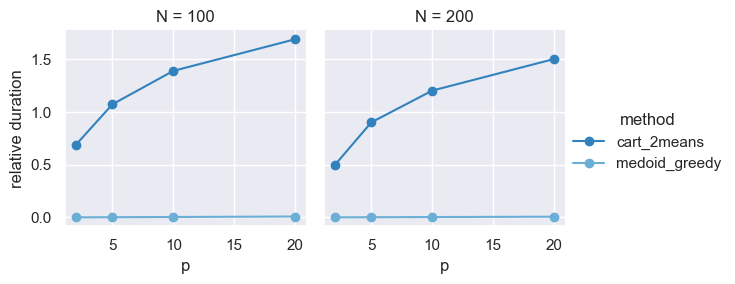

In [36]:
from plot_bench import *
sns.set_theme()

forest_df = make_forest_df(df, Ns=[100,200])
plot_forest_df(forest_df, ref_method='medoid_greedy')

/Users/matthieubulte/Documents/university/phd/merf/benchmark/plot_bench.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  _df = df.groupby(['N', 'p', 'method']).mean().reset_index().copy()


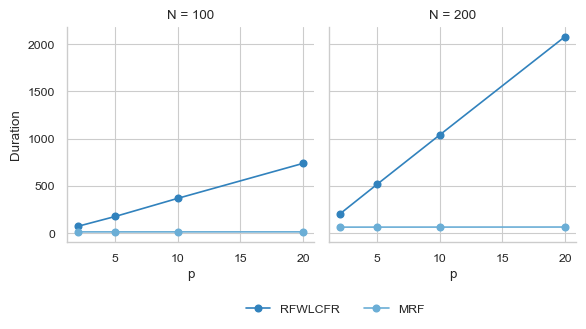

In [38]:
from plot_bench import *
sns.set_theme()
sns.set_style("white")
forest_df = make_forest_df(df, Ns=[100,200])
plot_forest_df(forest_df)
plt.savefig("./runtime_phase.pdf")

## MSE CART vs Medoid

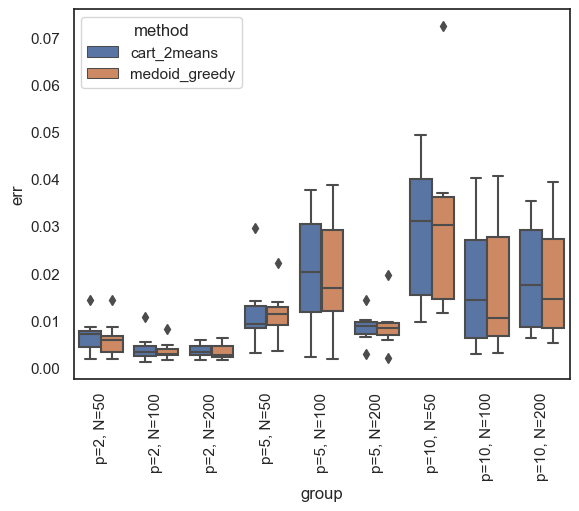

In [30]:
order = [
    f'p={p}, N={N}'
    for p in [2,5,10]
    for N in [50,100,200]
]
sns.set_style("white")
sns.boxplot(df, y='err', x='group', hue='method', order=order)
plt.xticks(rotation=90);
plt.savefig("./error_phase.pdf")

## Runtime CART vs Medoid

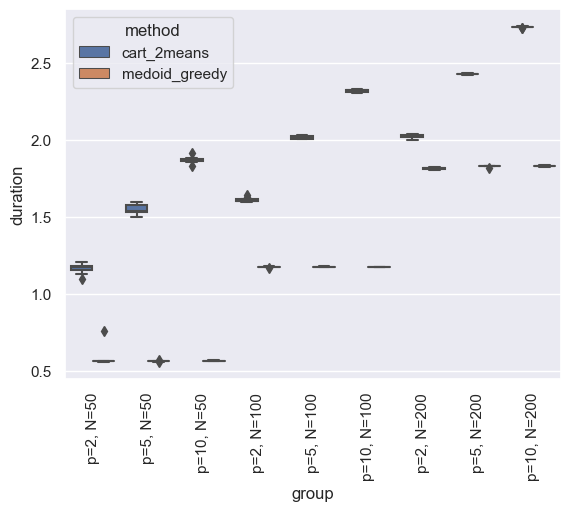

In [8]:
sns.boxplot(df, y=np.log10(df['duration']), x='group', hue='method')
plt.xticks(rotation=90);